# CatBoost Model

### Importing the libraries

In [1]:
# Base libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import randint
import pickle

In [2]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# Othe libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# import general custom data preprocessing functions
from General_Custom_Functions import *
General_Custom_Functions()


    Available General Custom Functions: 
    Check_Missing_Values(input_dataset)
    Move_Column_Last(input_dataset, target_variable)
    Check_Feature_Details(input_dataset, input_feature)
    Remove_Correlation(input_X_train)
    Remove_Multicollinearity(X_train, numerical_feature_list)
    Create_Feature_Selected_Dataset(input_X_train, input_y_train)
    


### Importing the dataset

In [5]:
dataset = pd.read_csv('Cleaned_Dataset.csv')

In [6]:
imported_dataset = dataset.copy()

In [7]:
imported_dataset.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,Price
0,Toyota,Camry,SEDAN,Used,Silver,NaN,Automatic,Gasoline,San Antonio,78233,5507.0,4.0,2.0,27.0,38.0,1,38997.0
1,Toyota,Supra,COUPE,Used,Red,NaN,Automatic,Gasoline,San Antonio,78233,7094.0,4.0,2.0,25.0,32.0,1,51997.0
2,Ford,F250,TRUCKS,Used,White,Java,Automatic,Diesel,San Antonio,78219,19135.0,8.0,4.0,NaN,NaN,2,80500.0
3,Ford,Escape,SUV,Used,Blue,NaN,Automatic,Flexible Fuel,San Antonio,78233,26196.0,4.0,2.0,21.0,29.0,3,24997.0
4,Toyota,RAV4,SUV,Used,Purple,NaN,Automatic,Gasoline,San Antonio,78233,37486.0,4.0,2.0,23.0,30.0,4,29287.0


In [8]:
imported_dataset.shape

(12481, 17)

In [9]:
Check_Missing_Values(imported_dataset)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,249,2.00,object
Interior_Color,484,3.88,object
Transmission_Type,41,0.33,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,int64


In [10]:
# convert Zip_Code to object
imported_dataset['Zip_Code'] = imported_dataset['Zip_Code'].astype(str)

### Split the dataset into training and test dataset

In [11]:
# decoupling the dependent and independent variables
X = imported_dataset.iloc[:, :-1]
y = imported_dataset.iloc[:, -1]

In [12]:
# Train, Test split
# from now on till the model training we will only use X_train, y_train
# X_test and y_test will only be used during model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# backup copy the dataset for feature reference
backup_X_train = X_train.copy()
backup_X_test = X_test.copy()

In [13]:
X_train.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age
713,MAZDA,MAZDA6,SEDAN,Used,Blue,Parchment,Automatic,Gasoline,San Diego,92111,26272.0,4.0,2.0,26.0,35.0,5
6255,Hyundai,Tucson,SUV,Used,Blue,Black,Automatic,Gasoline,Seattle,98036,20374.0,4.0,4.0,21.0,26.0,3
7457,INFINITI,Q50,SEDAN,Used,Brown,Wheat,Automatic,Gasoline,San Jose,95129,30547.0,6.0,2.0,20.0,29.0,4
1087,Toyota,RAV4,SUV,Used,Silver,Black,Automatic,Gasoline,San Diego,92108,24423.0,4.0,2.0,26.0,35.0,3
6820,BMW,X2,SUV,Used,White,Black,Automatic,Gasoline,San Jose,95051,32042.0,4.0,4.0,21.0,31.0,4


In [14]:
X_test.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age
5961,Tesla,Model S,HATCH,Used,Green,Black,Single-Speed,Electric,Seattle,98004,48962.0,NaN,2.0,NaN,NaN,9
12268,Hyundai,Santa Fe,SUV,Used,Silver,Gray,Automatic,Gasoline,Fort Worth,76051,27620.0,6.0,2.0,18.0,25.0,3
9706,Acura,TLX,SEDAN,Used,Gray,Graystone,Automatic,Gasoline,Jacksonville,32225,58967.0,4.0,2.0,24.0,35.0,6
4884,Toyota,Camry,SEDAN,Certified,Silver,Black,Automatic,Gasoline,Los Angeles,90266,7948.0,4.0,2.0,29.0,41.0,3
2325,Cadillac,Escalade,SUV,Used,Silver,Shale W/Cocoa Accents,Automatic,Gasoline,Denver,80203,64339.0,8.0,4.0,14.0,21.0,7


In [15]:
print(X_train.shape)
print(X_test.shape)

(9984, 16)
(2497, 16)


### Dealing with missing categorical features

In [16]:
Check_Missing_Values(X_train)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,190,1.90,object
Interior_Color,389,3.90,object
Transmission_Type,34,0.34,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,object


In [17]:
# replace missing categorical variables with the object Missing_Value_XYZ
X_train['Exterior_Color'] = X_train['Exterior_Color'].fillna('Missing_Value_EC')
X_train['Interior_Color'] = X_train['Interior_Color'].fillna('Missing_Value_IC')
X_train['Transmission_Type'] = X_train['Transmission_Type'].fillna('Missing_Value_TT')

### Dealing with missing numerical features

In [18]:
Check_Missing_Values(X_train)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,0,0.00,object
Interior_Color,0,0.00,object
Transmission_Type,0,0.00,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,object


In [19]:
# for Cylinder_Number, Wheel_Drive_Number we will replace the missing 
# values by mode (most_frequent), as they can have certain specific values
imputer_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_frequent.fit(X_train[['Cylinder_Number', 'Wheel_Drive_Number']])
X_train[['Cylinder_Number', 'Wheel_Drive_Number']] = imputer_frequent.transform(X_train[['Cylinder_Number', 'Wheel_Drive_Number']])

In [20]:
# for MPG_City, MPG_Highway we will replace the missing values by median, 
# as the mileage per gallon for cars varies in some range
# we could have also taken the mean here
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_median.fit(X_train[['MPG_City', 'MPG_Highway']])
X_train[['MPG_City', 'MPG_Highway']] = imputer_median.transform(X_train[['MPG_City', 'MPG_Highway']])

In [21]:
# for Mileage/Price we will replace the missing values by mean
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_mean.fit(X_train[['Mileage']])
X_train[['Mileage']] = imputer_mean.transform(X_train[['Mileage']])

### Get dummies for the categorical features

In [22]:
X_train.shape

(9984, 16)

In [23]:
# get dummies for the categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

In [24]:
X_train.shape

(9984, 1736)

### Feature selection

In [25]:
# now there are lot of features, let's rduce them to only important features
# create feature selected dataset from general custom function
# Runtime around 8 min
Create_Feature_Selected_Dataset(X_train, y_train)

Freature selection using RandomForestRegressor ...
Random State:  0
MPG_Highway            0.162066
Cylinder_Number        0.154941
Mileage                0.113583
Car_Age                0.102669
MPG_City               0.054368
Brand_BMW              0.035184
Brand_Mercedes-Benz    0.029590
Brand_Porsche          0.028852
Brand_Tesla            0.022672
Wheel_Drive_Number     0.019792
dtype: float64
Selected features:  19 	Total score:  0.8018765534817001
['MPG_Highway', 'Cylinder_Number', 'Mileage', 'Car_Age', 'MPG_City', 'Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Porsche', 'Brand_Tesla', 'Wheel_Drive_Number', 'Brand_Audi', 'Body_TRUCKS', 'Body_SUV', 'Brand_Land Rover', 'Fuel_Type_Gasoline', 'Brand_Lexus', 'Brand_Ford', 'Model_Expedition', 'Model_Corvette']
Random State:  1
Random State:  2
Random State:  3
Random State:  4
Random State:  5
Random State:  6
Random State:  7
Random State:  8
Random State:  9

Final selected features: 16
Final feature selected list: 
['Car_Age', 'MPG_Ci

In [26]:
X_train.shape

(9984, 16)

### Feature scaling of the training dataset

In [27]:
# numerical feature list
# feature scaling will be done on numerical features
numerical_feature_list_X_train = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
print(numerical_feature_list_X_train)

['Mileage', 'Cylinder_Number', 'Wheel_Drive_Number', 'MPG_City', 'MPG_Highway', 'Car_Age']


In [28]:
# Feature scaling of numerical features
standard_scaler = StandardScaler()
X_train[numerical_feature_list_X_train] = standard_scaler.fit_transform(X_train[numerical_feature_list_X_train])

In [29]:
X_train.head()

,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,Brand_Audi,Brand_BMW,Brand_Land Rover,Brand_Lexus,Brand_Mercedes-Benz,Brand_Porsche,Brand_Tesla,Body_SUV,Body_TRUCKS,Fuel_Type_Gasoline
713,-0.017836,-0.783186,-0.905303,0.922240,1.160537,0.866897,0,0,0,0,0,0,0,0,0,1
6255,-0.359219,-0.783186,1.104603,-0.171123,-0.572141,-0.290202,0,0,0,0,0,0,0,1,0,1
7457,0.229605,0.649582,-0.905303,-0.389795,0.005418,0.288348,0,0,0,0,0,0,0,0,0,1
1087,-0.124858,-0.783186,-0.905303,0.922240,1.160537,-0.290202,0,0,0,0,0,0,0,1,0,1
6820,0.316137,-0.783186,1.104603,-0.171123,0.390458,0.288348,0,1,0,0,0,0,0,1,0,1


### Remove correlation from training dataset

In [30]:
# Remove correlation from the trainig dataset
Remove_Correlation(X_train)

Correlated pairs ... 

MPG_Highway         MPG_City              0.901645
Car_Age             Mileage               0.788841
MPG_City            Cylinder_Number       0.717722
MPG_Highway         Cylinder_Number       0.684890
Body_TRUCKS         Cylinder_Number       0.446117
                    MPG_Highway           0.407129
MPG_Highway         Wheel_Drive_Number    0.381925
Body_TRUCKS         Body_SUV              0.354672
Fuel_Type_Gasoline  Brand_Tesla           0.342503
Body_TRUCKS         MPG_City              0.332527
dtype: float64

Feature dropped: 
['MPG_Highway']


In [31]:
X_train.shape

(9984, 15)

### Remove multicollinearity from trainig dataset

In [32]:
# numerical feature list
numerical_feature_list_X_train = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
print(numerical_feature_list_X_train)

['Mileage', 'Cylinder_Number', 'Wheel_Drive_Number', 'MPG_City', 'Car_Age']


In [33]:
# Remove multicollinearity from the trainig dataset
Remove_Multicollinearity(X_train, numerical_feature_list_X_train)

Good. VIF is less than 10.

Feature dropped: 
[]


,VIF,Features
4,2.658282,Car_Age
0,2.651851,Mileage
3,2.234056,MPG_City
1,2.081606,Cylinder_Number
2,1.100626,Wheel_Drive_Number


In [111]:
print(X_train.columns)

Index(['Mileage', 'Cylinder_Number', 'Wheel_Drive_Number', 'MPG_City',
       'Car_Age', 'Brand_Audi', 'Brand_BMW', 'Brand_Land Rover', 'Brand_Lexus',
       'Brand_Mercedes-Benz', 'Brand_Porsche', 'Brand_Tesla', 'Body_SUV',
       'Body_TRUCKS', 'Fuel_Type_Gasoline'],
      dtype='object')


In [34]:
X_train.shape

(9984, 15)

### Training the CatBoost model on the training dataset

In [35]:
# CatBoost Model
model_CBR = CatBoostRegressor(verbose=False)

In [36]:
# Randomized Search CV param_distributions for CatBoost

# iterations: int -> 100-1000 
iterations = [int(x) for x in np.linspace(100, 1000, num = 5)]
# learning_rate: float -> 0.01–0.3
learning_rate = [round(x, 2) for x in np.linspace(0.01, 0.3, num = 5)]
# depth: int -> 2–10 
depth = [int(x) for x in np.linspace(2, 10, num = 5)]
# l2_leaf_reg: int -> 2–30 
l2_leaf_reg = [int(x) for x in np.linspace(2, 30, num = 5)]
# border_count: int -> 10-100
border_count = [int(x) for x in np.linspace(10, 100, num = 5)]


In [37]:
# Create the random grid
random_param_distributions = {
                            'iterations': iterations,
                            'learning_rate': learning_rate,
                            'depth': depth,
                            'l2_leaf_reg': l2_leaf_reg,
                            'border_count': border_count
                            }
print(random_param_distributions)

{'iterations': [100, 325, 550, 775, 1000], 'learning_rate': [0.01, 0.08, 0.16, 0.23, 0.3], 'depth': [2, 4, 6, 8, 10], 'l2_leaf_reg': [2, 9, 16, 23, 30], 'border_count': [10, 32, 55, 77, 100]}


In [38]:
# RandomizedSearchCV
randomized_search_cv = RandomizedSearchCV(
                                        estimator = model_CBR,
                                        param_distributions = random_param_distributions,
                                        n_iter = 20,
                                        cv = 10, 
                                        random_state = 0,
                                        verbose = 1, 
                                        n_jobs = 1
                                        )

In [39]:
# Run time: 5 min (Fitting 10 folds for each of 20 candidates, totalling 200 fits)
# with depth = [int(x) for x in np.linspace(2, 10, num = 5)]
randomized_search_cv.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostRegressor object at 0x1211b0f40>,
                   n_iter=20, n_jobs=1,
                   param_distributions={'border_count': [10, 32, 55, 77, 100],
                                        'depth': [2, 4, 6, 8, 10],
                                        'iterations': [100, 325, 550, 775,
                                                       1000],
                                        'l2_leaf_reg': [2, 9, 16, 23, 30],
                                        'learning_rate': [0.01, 0.08, 0.16,
                                                          0.23, 0.3]},
                   random_state=0, verbose=1)

In [40]:
model_best_score = randomized_search_cv.best_score_
model_best_score

0.8142296209597149

In [41]:
randomized_search_cv.best_params_

{'learning_rate': 0.08,
 'l2_leaf_reg': 2,
 'iterations': 775,
 'depth': 8,
 'border_count': 55}

### Model performance metrics for training dataset

In [42]:
y_hat = randomized_search_cv.predict(X_train)

In [43]:
# R-Square is a good measure to determine how well the model fits the dependent variables. 
# However, it does not take into consideration of overfitting problem.
# High R-Squre value means better fitting.
r2 = randomized_search_cv.score(X_train, y_train)
print('R2:', r2)

R2: 0.8833322565250905


In [44]:
# If regression model has many independent variables, it may fit very well to the training dataset 
# but performs badly for testing dataset. Adjusted R Square penalizes additional independent variables 
# added to the model and adjust the metric to prevent overfitting issues.
# High Adjusted R-Squre value means better fitting.
r2 = randomized_search_cv.score(X_train, y_train)
n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adjusted R2:', adjusted_r2)

Adjusted R2: 0.8831566931069401


Text(0.5, 1.0, 'Residuals PDF On Test Dataset')

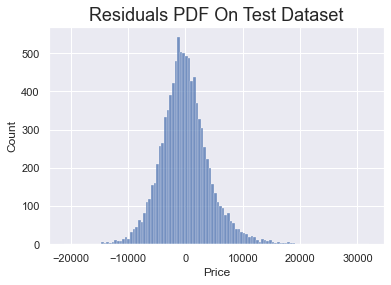

In [45]:
# useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.histplot(y_train - y_hat)
plt.title('Residuals PDF On Train Dataset', size=18)
# In the best case scenario this plot should be normally distributed
# long left tail means over predition
# long right tail implies under prediction

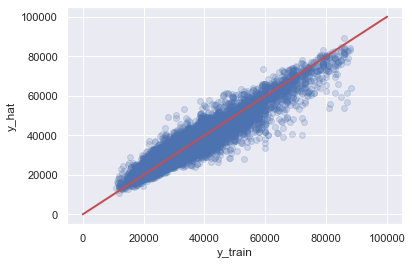

In [46]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat, alpha=0.2)
plt.xlabel('y_train')
plt.ylabel('y_hat')
plt.plot([0, 100000], [0, 100000], color = 'r', linewidth = 2)
plt.show()

In [47]:
# construct model performance evaluation dataframe
performance_train_dataset = backup_X_train.copy()
y_train_difference_percentage = abs(y_train - y_hat)*100/y_train
performance_train_dataset['y_train'] = y_train
performance_train_dataset['y_hat'] = y_hat
performance_train_dataset['y_train_difference(%)'] = y_train_difference_percentage

In [48]:
performance_train_dataset.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_train,y_hat,y_train_difference(%)
713,MAZDA,MAZDA6,SEDAN,Used,Blue,Parchment,Automatic,Gasoline,San Diego,92111,26272.0,4.0,2.0,26.0,35.0,5,23779.0,20391.272400,14.246720
6255,Hyundai,Tucson,SUV,Used,Blue,Black,Automatic,Gasoline,Seattle,98036,20374.0,4.0,4.0,21.0,26.0,3,28090.0,33506.173533,19.281501
7457,INFINITI,Q50,SEDAN,Used,Brown,Wheat,Automatic,Gasoline,San Jose,95129,30547.0,6.0,2.0,20.0,29.0,4,28695.0,33352.510173,16.231086
1087,Toyota,RAV4,SUV,Used,Silver,Black,Automatic,Gasoline,San Diego,92108,24423.0,4.0,2.0,26.0,35.0,3,29826.0,28290.472767,5.148284
6820,BMW,X2,SUV,Used,White,Black,Automatic,Gasoline,San Jose,95051,32042.0,4.0,4.0,21.0,31.0,4,30499.0,31233.883947,2.409535


In [49]:
# check data for which model fitting is poor
performance_train_dataset.sort_values(by=['y_train_difference(%)'], ascending=False).head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_train,y_hat,y_train_difference(%)
1391,Ford,Fiesta,SEDAN,Used,Black,Charcoal Black,NaN,Gasoline,Chicago,60546,12813.0,4.0,2.0,NaN,NaN,3,15477.0,28992.137142,87.324011
4305,FIAT,500,HATCH,Used,Gray,Black,Single-Speed,Electric,Los Angeles,90706,14204.0,NaN,2.0,NaN,NaN,4,13288.0,24435.256868,83.889651
10446,FIAT,500,HATCH,Used,Gray,Black,Single-Speed,Electric,Phoenix,85015,23661.0,NaN,2.0,NaN,NaN,4,12573.0,23063.921152,83.440079
7865,Nissan,Frontier,TRUCKS,Certified,Black,Steel,Automatic,Gasoline,New York,11372,23924.0,6.0,4.0,15.0,21.0,4,27998.0,49094.815314,75.351151
10998,Dodge,Journey,SUV,Used,White,Tan,Automatic,Gasoline,Indianapolis,46219,54276.0,6.0,4.0,16.0,24.0,4,21797.0,37292.237900,71.088856


In [50]:
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_hat))
nrmse_train = rmse_train/y_train.mean()
print('Normalized RMSE of trained dataset: {:.2f}'.format(nrmse_train))

Normalized RMSE of trained dataset: 0.12


### Model performance metrics for test dataset

In [51]:
# Before Testing
# X_test and X_train should be of same data format
# dealing with missing categorical features in X_test
# dealing with missing numerical features in X_test using transform method
# get dummies for categorical features of X_test
# feature scale the numerical features of X_test using the transform method
# keep only thore columns in X_test as that of X_train

In [97]:
# X_test = backup_X_test.copy()

In [ ]:
X_test.head()

In [98]:
Check_Missing_Values(X_test)

,Missing_Data,Missing_Data (%),Data_Type
Brand,0,0.00,object
Model,0,0.00,object
Body,0,0.00,object
Certification,0,0.00,object
Exterior_Color,59,2.36,object
Interior_Color,95,3.80,object
Transmission_Type,7,0.28,object
Fuel_Type,0,0.00,object
City,0,0.00,object
Zip_Code,0,0.00,object


In [100]:
# replace missing categorical variables with the object Missing_Value_XYZ
X_test['Exterior_Color'] = X_test['Exterior_Color'].fillna('Missing_Value_EC')
X_test['Interior_Color'] = X_test['Interior_Color'].fillna('Missing_Value_IC')
X_test['Transmission_Type'] = X_test['Transmission_Type'].fillna('Missing_Value_TT')

In [101]:
# now impute the X_test with the same model that was used to impute the X_train
X_test[['Cylinder_Number', 'Wheel_Drive_Number']] = imputer_frequent.transform(X_test[['Cylinder_Number', 'Wheel_Drive_Number']])
X_test[['MPG_City', 'MPG_Highway']] = imputer_median.transform(X_test[['MPG_City', 'MPG_Highway']])
X_test[['Mileage']] = imputer_mean.transform(X_test[['Mileage']])

In [102]:
# get dummies for the categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [103]:
# Feature scaling of numerical features
numerical_feature_list_X_test = list(X_test.select_dtypes(include=['int64', 'float64']).columns)
print(numerical_feature_list_X_test)
X_test[numerical_feature_list_X_test] = standard_scaler.transform(X_test[numerical_feature_list_X_test]) # only transform

['Mileage', 'Cylinder_Number', 'Wheel_Drive_Number', 'MPG_City', 'MPG_Highway', 'Car_Age']


In [104]:
print(X_train.shape)
print(X_test.shape)

(9984, 15)
(2497, 1112)


In [105]:
# only keep the columns same as X_train in X_test
X_train_feature_list = X_train.columns.values.tolist()
X_test = X_test[X_train_feature_list]

In [106]:
print(X_train.shape)
print(X_test.shape)

(9984, 15)
(2497, 15)


In [107]:
X_test.head()

,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,Car_Age,Brand_Audi,Brand_BMW,Brand_Land Rover,Brand_Lexus,Brand_Mercedes-Benz,Brand_Porsche,Brand_Tesla,Body_SUV,Body_TRUCKS,Fuel_Type_Gasoline
5961,1.295484,-0.783186,-0.905303,-0.171123,3.181094,0,0,0,0,0,0,1,0,0,0
12268,0.060187,0.649582,-0.905303,-0.827141,-0.290202,0,0,0,0,0,0,0,1,0,1
9706,1.874583,-0.783186,-0.905303,0.484895,1.445446,0,0,0,0,0,0,0,0,0,1
4884,-1.078448,-0.783186,-0.905303,1.578258,-0.290202,0,0,0,0,0,0,0,0,0,1
2325,2.185520,2.082349,1.104603,-1.701831,2.023996,0,0,0,0,0,0,0,1,0,1


In [90]:
y_pred = randomized_search_cv.predict(X_test)

Text(0.5, 1.0, 'Residuals PDF On Test Dataset')

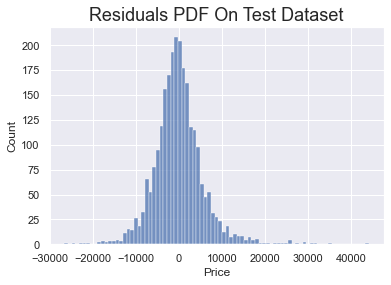

In [91]:
# useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.histplot(y_test - y_pred)
plt.title('Residuals PDF On Test Dataset', size=18)
# In the best case scenario this plot should be normally distributed
# long left tail means over predition
# long right tail implies under prediction

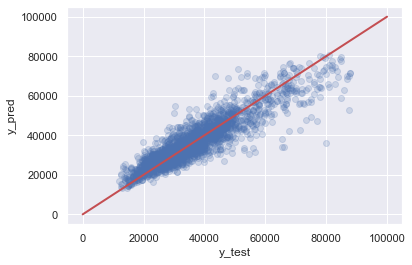

In [92]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot([0, 100000], [0, 100000], color = 'r', linewidth = 2)
plt.show()

In [93]:
# construct model performance evaluation dataframe
performance_test_dataset = backup_X_test.copy()
y_test_difference_percentage = abs(y_test - y_pred)*100/y_test
performance_test_dataset['y_test'] = y_test
performance_test_dataset['y_pred'] = y_pred
performance_test_dataset['y_test_difference(%)'] = y_test_difference_percentage

In [94]:
performance_test_dataset.head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_test,y_pred,y_test_difference(%)
5961,Tesla,Model S,HATCH,Used,Green,Black,Single-Speed,Electric,Seattle,98004,48962.0,NaN,2.0,NaN,NaN,9,40492.0,35897.472832,11.346753
12268,Hyundai,Santa Fe,SUV,Used,Silver,Gray,Automatic,Gasoline,Fort Worth,76051,27620.0,6.0,2.0,18.0,25.0,3,29000.0,36109.843209,24.516701
9706,Acura,TLX,SEDAN,Used,Gray,Graystone,Automatic,Gasoline,Jacksonville,32225,58967.0,4.0,2.0,24.0,35.0,6,19947.0,18874.680566,5.375843
4884,Toyota,Camry,SEDAN,Certified,Silver,Black,Automatic,Gasoline,Los Angeles,90266,7948.0,4.0,2.0,29.0,41.0,3,27595.0,26558.299061,3.756843
2325,Cadillac,Escalade,SUV,Used,Silver,Shale W/Cocoa Accents,Automatic,Gasoline,Denver,80203,64339.0,8.0,4.0,14.0,21.0,7,47500.0,40556.799940,14.617263


In [109]:
# check data for which model fitting is poor
performance_test_dataset.sort_values(by=['y_test_difference(%)'], ascending=False).head()

,Brand,Model,Body,Certification,Exterior_Color,Interior_Color,Transmission_Type,Fuel_Type,City,Zip_Code,Mileage,Cylinder_Number,Wheel_Drive_Number,MPG_City,MPG_Highway,Car_Age,y_test,y_pred,y_test_difference(%)
4981,FIAT,500,HATCH,Used,Gray,Black,Single-Speed,Electric,Los Angeles,90640,21667.0,NaN,2.0,NaN,NaN,4,13199.0,24631.634770,86.617431
10510,Lexus,ES 350,SEDAN,Used,NaN,Other,Automatic,Gasoline,Phoenix,85226,31210.0,6.0,2.0,21.0,30.0,4,19685.0,36693.198628,86.401822
4685,FIAT,500,HATCH,Used,Silver,Black,Single-Speed,Electric,Los Angeles,90250,17749.0,NaN,2.0,NaN,NaN,4,13800.0,25389.442100,83.981464
10607,Nissan,Frontier,TRUCKS,Used,Black,Steel,Automatic,Gasoline,Phoenix,85284,18599.0,6.0,4.0,15.0,21.0,3,30495.0,54742.197571,79.512043
7255,FIAT,500,HATCH,Used,Gray,Black,Single-Speed,Electric,San Jose,95136,24159.0,NaN,2.0,NaN,NaN,4,13300.0,23622.072888,77.609571


In [67]:
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
nrmse_test = rmse_test/y_test.mean()
print('Normalized RMSE of test dataset: {:.2f}'.format(nrmse_test))

Normalized RMSE of test dataset: 0.16


In [68]:
# difference between nrmse_train and nrmse_test
nrmse_difference = (nrmse_test - nrmse_train)*100/nrmse_train
print('Best score of the model on training dataset: {:.2f}'.format(model_best_score))
print('Normalized RMSE of trained dataset: {:.2f}'.format(nrmse_train))
print('Normalized RMSE of test dataset: {:.2f}'.format(nrmse_test))
print('Difference between nrmse_train and nrmse_test: {:.2f} %'.format(nrmse_difference))

Best score of the model on training dataset: 0.81
Normalized RMSE of trained dataset: 0.12
Normalized RMSE of test dataset: 0.16
Difference between nrmse_train and nrmse_test: 26.72 %


### Pickle the standard scalar and catboost model

In [69]:
# Pickle the model
# open a file, where you ant to store the data
standard_scaler_pkl = open('catboost_standard_scaler.pkl', 'wb')
regression_model_pkl = open('catboost_regression_model.pkl', 'wb')
# dump information to that file
pickle.dump(standard_scaler, standard_scaler_pkl)
pickle.dump(randomized_search_cv, regression_model_pkl)

### Create requirements.txt file

In [70]:
# $ cd my-project/
# $ virtualenv venv
# $ source venv/bin/activate
# $ pip install <package>

In [71]:
# to get the requirements.txt file 
# $ pip3 freeze > requirements.txt
# $ python3 -m  pipreqs.pipreqs .